# Initial thoughts

I want to start with some raw metrics like count of files, lines of code.
This is important to give me some context.
Example, if a package consists of 1 file, with 5 lines of code. Then naturally that package will have different metrics later on, such as no cyclomatic complexity, because the file only consists of imports.


# Dependencies setup

In [ ]:
import os
import sys
import subprocess

def enforce_numpy_version():
    """
    Ensure that NumPy is installed and is a version below 2.x.
    If a 2.x version (or higher) is found, downgrade to a 1.x version
    and instruct the user to restart the kernel manually if running interactively.
    """
    try:
        import numpy as np
        major_version = int(np.__version__.split('.')[0])
        if major_version >= 2:
            print(f"Detected NumPy version {np.__version__}. Downgrading to numpy<2...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "numpy<2"])
            if "ipykernel" in sys.modules:
                print("Please restart your Jupyter kernel manually after downgrading NumPy.")
                sys.exit(0)
            else:
                print("Restarting the script after downgrading NumPy...")
                os.execv(sys.executable, [sys.executable] + sys.argv)
        else:
            print(f"NumPy version {np.__version__} is compatible (version <2).")
    except ImportError:
        print("NumPy is not installed. Installing numpy<2...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "numpy<2"])
        if "ipykernel" in sys.modules:
            print("Please restart your Jupyter kernel manually after installing NumPy.")
            sys.exit(0)
        else:
            print("Restarting the script after installing NumPy...")
            os.execv(sys.executable, [sys.executable] + sys.argv)

def install_package(package):
    """
    Try to import a package. If it’s not found, install it using pip.
    If pip fails for any reason, catch the exception and print an error message.
    """
    try:
        # Replace dashes with underscores in case the module name differs from the package name.
        __import__(package.replace('-', '_'))
        print(f"{package} is already installed.")
    except ImportError:
        print(f"Installing {package}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        except subprocess.CalledProcessError as e:
            print(f"Failed to install {package}. Error: {e}")

if __name__ == "__main__":
    # Ensure NumPy is compatible before proceeding.
    enforce_numpy_version()
    
    # List of packages to install.
    packages = [
        'radon',
        'matplotlib',
        'pandas',
        'networkx',
        'pydot',
        'squarify',
        'pylint',
        'graphviz',
        'pyan3',
        'prospector',
        'adjustText'
    ]
    
    for pkg in packages:
        install_package(pkg)
    
    print("All packages have been checked and installed as needed.")


NumPy version 1.26.4 is compatible (version <2).
radon is already installed.
matplotlib is already installed.
pandas is already installed.
networkx is already installed.
pydot is already installed.
squarify is already installed.
pylint is already installed.
graphviz is already installed.
Installing pyan3...
prospector is already installed.
All packages have been checked and installed as needed.


In [16]:
import datetime
import os
import sys
import subprocess
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from pathlib import Path
from collections import defaultdict
import networkx as nx
import ast
import shutil
import tempfile
from IPython.display import Image, display

# Path setup

In [17]:
TOOLS_DIR = os.getcwd()  # Expected: ...\Tools
BASE_DIR = os.path.abspath(os.path.join(TOOLS_DIR, '..'))
DATA_DIR = os.path.join(BASE_DIR, 'Data')

# Our repos to analyse:
API_DIR = os.path.join(DATA_DIR, 'api')
WEB_DIR = os.path.join(DATA_DIR, 'web')

# Subdirectories for specific APIs:
API_ZEEGUU_DIR = os.path.join(DATA_DIR, 'api', 'zeeguu')
API_TOOLS_DIR = os.path.join(DATA_DIR, 'api', 'tools')

#Tools specific paths:
RADON_OUTPUT_DIR = os.path.join(BASE_DIR, 'output', 'radon')
os.makedirs(RADON_OUTPUT_DIR, exist_ok=True)

PYREVERSE_OUTPUT_DIR = os.path.join(BASE_DIR, 'output', 'pyreverse')
os.makedirs(PYREVERSE_OUTPUT_DIR, exist_ok=True)

'''

Data
 └── api <- Root of solution i am analysing lives here
      └── tools        
      └── zeeguu
           ├── api
           │    └── endpoints
           ├── core
           ├── config
           └── logging
Tools
 └── toolscript.ipynb <- My script lives here.
Output
 └──radon
       └── someGraph.png <- Image output of tools should be here
       
'''

'\n\nData\n └── api <- Root of solution i am analysing lives here\n      └── tools        \n      └── zeeguu\n           ├── api\n           │    └── endpoints\n           ├── core\n           ├── config\n           └── logging\nTools\n └── toolscript.ipynb <- My script lives here.\nOutput\n └──radon\n       └── someGraph.png <- Image output of tools should be here\n       \n'

# Analyzation project(s) setup

In [18]:
def clone_repo(repo_url, target_dir):
    """
    Clone a git repository from repo_url into target_dir.
    Also create an empty __init__.py file in the repository's root.
    """
    # Ensure the parent directory exists.
    parent_dir = os.path.dirname(target_dir)
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)
        print(f"Created parent directory: {parent_dir}")
    
    # Clone the repository if not already present.
    if not os.path.exists(target_dir):
        subprocess.run(["git", "clone", repo_url, target_dir], check=True)
        print(f"Repository cloned from {repo_url} into {target_dir}")
    else:
        print(f"Repository already exists at {target_dir}")
    
    # Create an empty __init__.py file in the repo root if it doesn't already exist.
    init_file = os.path.join(target_dir, '__init__.py')
    if not os.path.exists(init_file):
        open(init_file, 'w').close()  # This creates an empty file.
        print(f"Empty __init__.py created in {target_dir}")
    else:
        print(f"__init__.py already exists in {target_dir}")

# Clone the zeeguu/api repository.
clone_repo("https://github.com/zeeguu/api", API_DIR)

# Clone the zeeguu/web repository.
clone_repo("https://github.com/zeeguu/web", WEB_DIR)

Repository already exists at c:\Users\jgrum\Documents\Programming\ArchitecturalRecovery\Data\api
__init__.py already exists in c:\Users\jgrum\Documents\Programming\ArchitecturalRecovery\Data\api
Repository already exists at c:\Users\jgrum\Documents\Programming\ArchitecturalRecovery\Data\web
__init__.py already exists in c:\Users\jgrum\Documents\Programming\ArchitecturalRecovery\Data\web


# Radon

https://pypi.org/project/radon/

https://radon.readthedocs.io/en/latest/


## Why Radon

Radon is a tool i found great for providing code metrics, especially an overview of some of the common raw metrics like lines of code, number of functions, etc. This will give me a great initial overview, of where the work is placed in the project.


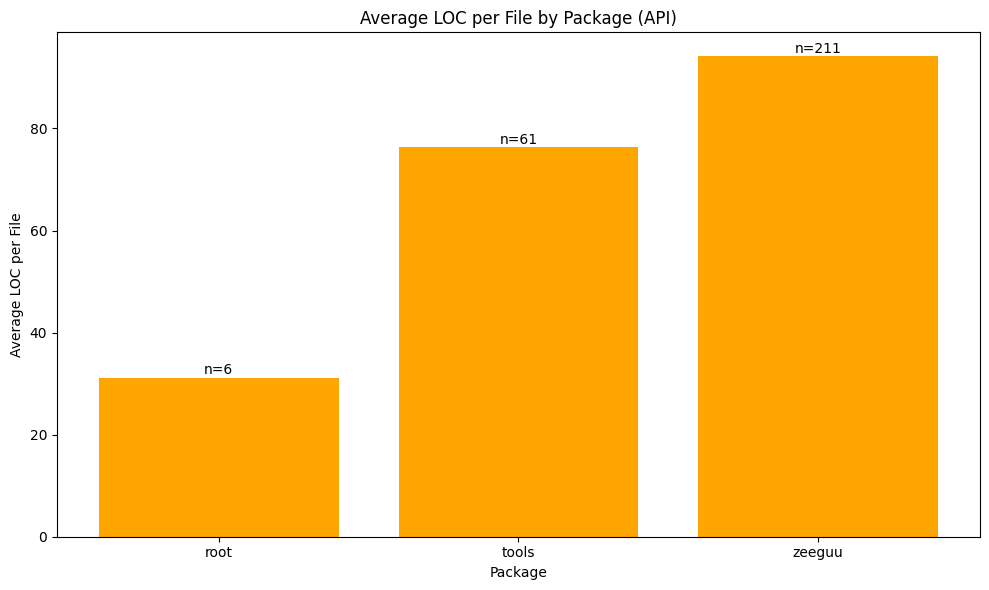

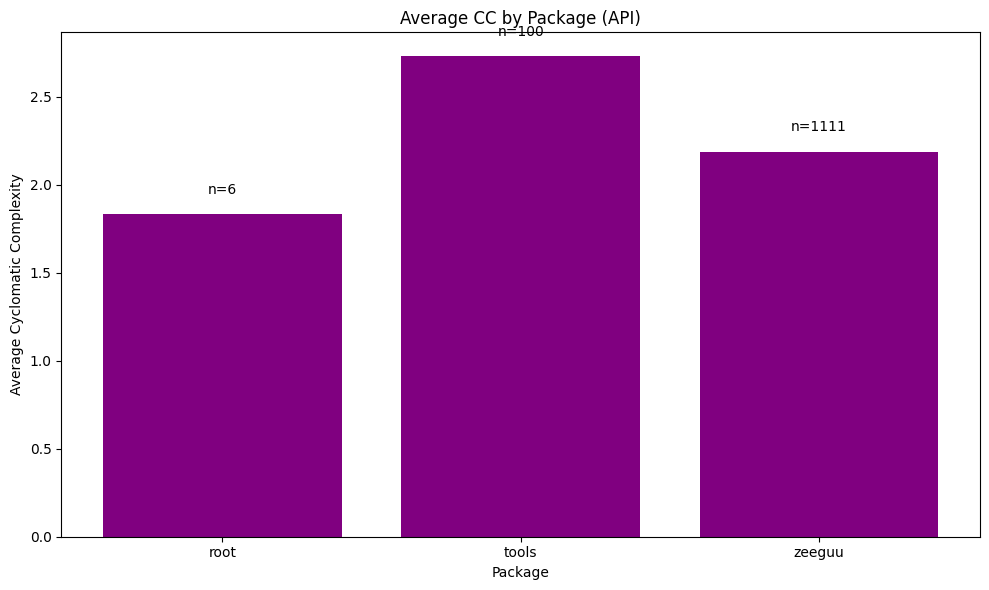

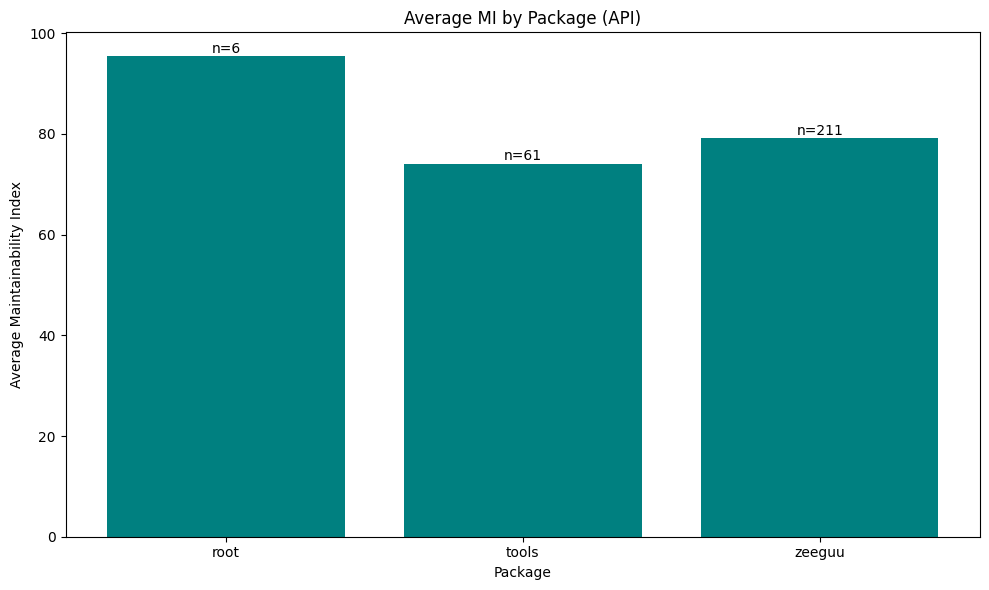

In [19]:
def aggregate_cc_by_package(base_dir):
    cmd = [sys.executable, "-m", "radon", "cc", base_dir, "-j", "-s", "-a"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    pkg_data = defaultdict(list)
    for filepath, funcs in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        pkg = relpath.split(os.sep)[0] if os.sep in relpath else "root"
        for func in funcs:
            pkg_data[pkg].append(func["complexity"])
    return pkg_data

def aggregate_mi_by_package(base_dir):
    cmd = [sys.executable, "-m", "radon", "mi", base_dir, "-j"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    pkg_data = defaultdict(list)
    for filepath, mi_value in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        pkg = relpath.split(os.sep)[0] if os.sep in relpath else "root"
        if isinstance(mi_value, dict):
            pkg_data[pkg].append(mi_value.get("mi", 0))
        else:
            pkg_data[pkg].append(mi_value)
    return pkg_data

def aggregate_raw_by_package(base_dir):
    cmd = [sys.executable, "-m", "radon", "raw", base_dir, "-j", "-s"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    metrics = ["loc", "lloc", "sloc", "comments", "single_comments", "multi", "blank"]
    pkg_totals = defaultdict(lambda: {metric: 0 for metric in metrics})
    pkg_file_count = defaultdict(int)
    for filepath, stats in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        pkg = relpath.split(os.sep)[0] if os.sep in relpath else "root"
        pkg_file_count[pkg] += 1
        for metric in metrics:
            pkg_totals[pkg][metric] += stats.get(metric, 0)
    return pkg_totals, pkg_file_count

# --- Plot Average Cyclomatic Complexity by Package with annotations ---
if __name__ == "__main__":
    
    # --- Plot Average LOC per File by Package with annotations ---
    raw_pkg, pkg_file_count = aggregate_raw_by_package(API_DIR)
    pkg_names_raw = list(raw_pkg.keys())
    avg_loc = [raw_pkg[p]['loc'] / pkg_file_count[p] if pkg_file_count[p] else 0 for p in pkg_names_raw]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(pkg_names_raw, avg_loc, color='orange')
    plt.xlabel("Package")
    plt.ylabel("Average LOC per File")
    plt.title("Average LOC per File by Package (API)")
    for bar, pkg in zip(bars, pkg_names_raw):
        count = pkg_file_count[pkg]
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f"n={count}", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(RADON_OUTPUT_DIR, 'average_loc_by_package.png'))
    plt.show()
    
    # Aggregate cyclomatic complexity data
    cc_pkg = aggregate_cc_by_package(API_DIR)
    pkg_names = list(cc_pkg.keys())
    avg_cc = [sum(cc_pkg[p]) / len(cc_pkg[p]) if cc_pkg[p] else 0 for p in pkg_names]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(pkg_names, avg_cc, color='purple')
    plt.xlabel("Package")
    plt.ylabel("Average Cyclomatic Complexity")
    plt.title("Average CC by Package (API)")
    for bar, pkg in zip(bars, pkg_names):
        count = len(cc_pkg[pkg])
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f"n={count}", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(RADON_OUTPUT_DIR, 'average_cc_by_package.png'))
    plt.show()

    # --- Plot Average Maintainability Index by Package with annotations ---
    mi_pkg = aggregate_mi_by_package(API_DIR)
    pkg_names_mi = list(mi_pkg.keys())
    avg_mi = [sum(mi_pkg[p]) / len(mi_pkg[p]) if mi_pkg[p] else 0 for p in pkg_names_mi]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(pkg_names_mi, avg_mi, color='teal')
    plt.xlabel("Package")
    plt.ylabel("Average Maintainability Index")
    plt.title("Average MI by Package (API)")
    for bar, pkg in zip(bars, pkg_names_mi):
        count = len(mi_pkg[pkg])
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f"n={count}", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(RADON_OUTPUT_DIR, 'average_mi_by_package.png'))
    plt.show()



### Intermediate Analysis

Here we can quickly see that the root only has 6 functions and few lines of code.
Most of the code resides in either /Tools or /Zeeguu, having around 80 lines of code per file, where as Tools consists of 70 functions and zeeguu has the majority of code, containing 282 functions.

Besides Lines of Code and number of functions, Radon will also provide:
* Cyclomatic Complexity, which looks at number of decisions a block of code contains
* Maintainability index. Which is a combination of 4 other metrics https://radon.readthedocs.io/en/latest/intro.html#maintainability-index, being the Halstead index (https://radon.readthedocs.io/en/latest/intro.html#halstead-metrics), which looks at distinct number of operators and operands compared to the total number. As well as the Cyclomatic Complexity, Source Lines of Code (SLOC), and number of comments. A low Maintainability index is bad, and a high one is good.

We can see that Tools have a higher CC and lower maintainabiltiy index than Zeeguu.

So now i want to check the subdirectories in /Tools and /Zeeguu

Running analysis for: zeeguu (Directory: c:\Users\jgrum\Documents\Programming\ArchitecturalRecovery\Data\api\zeeguu)


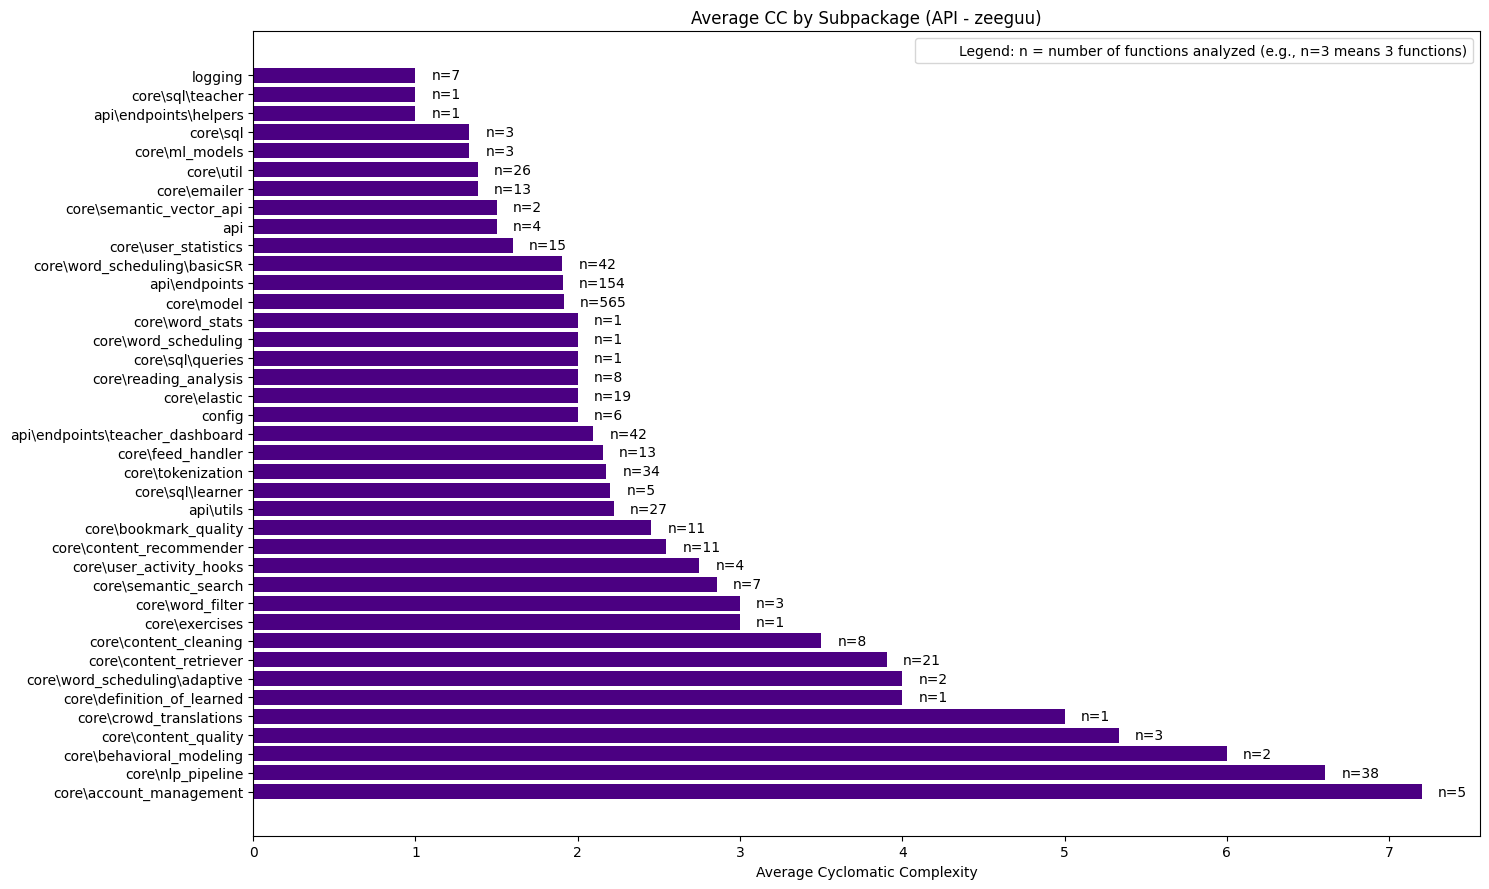

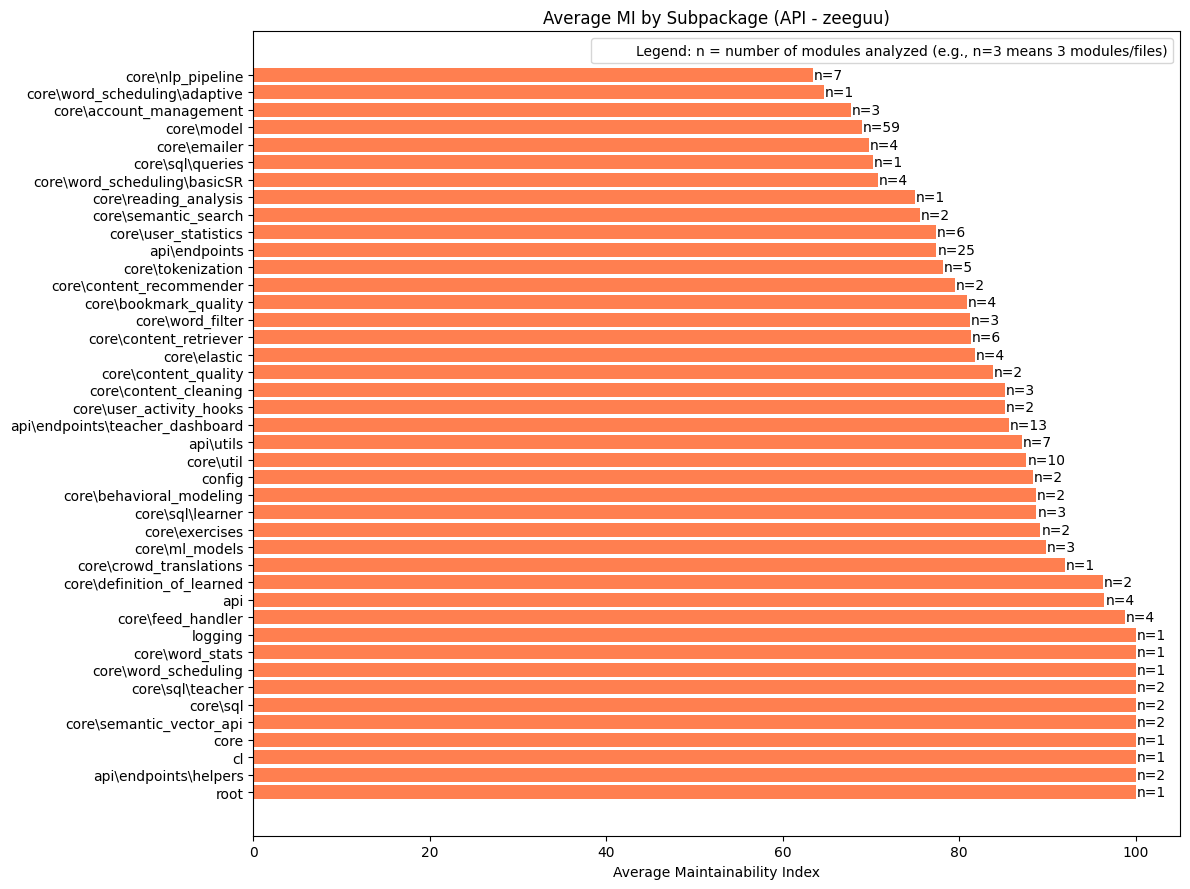

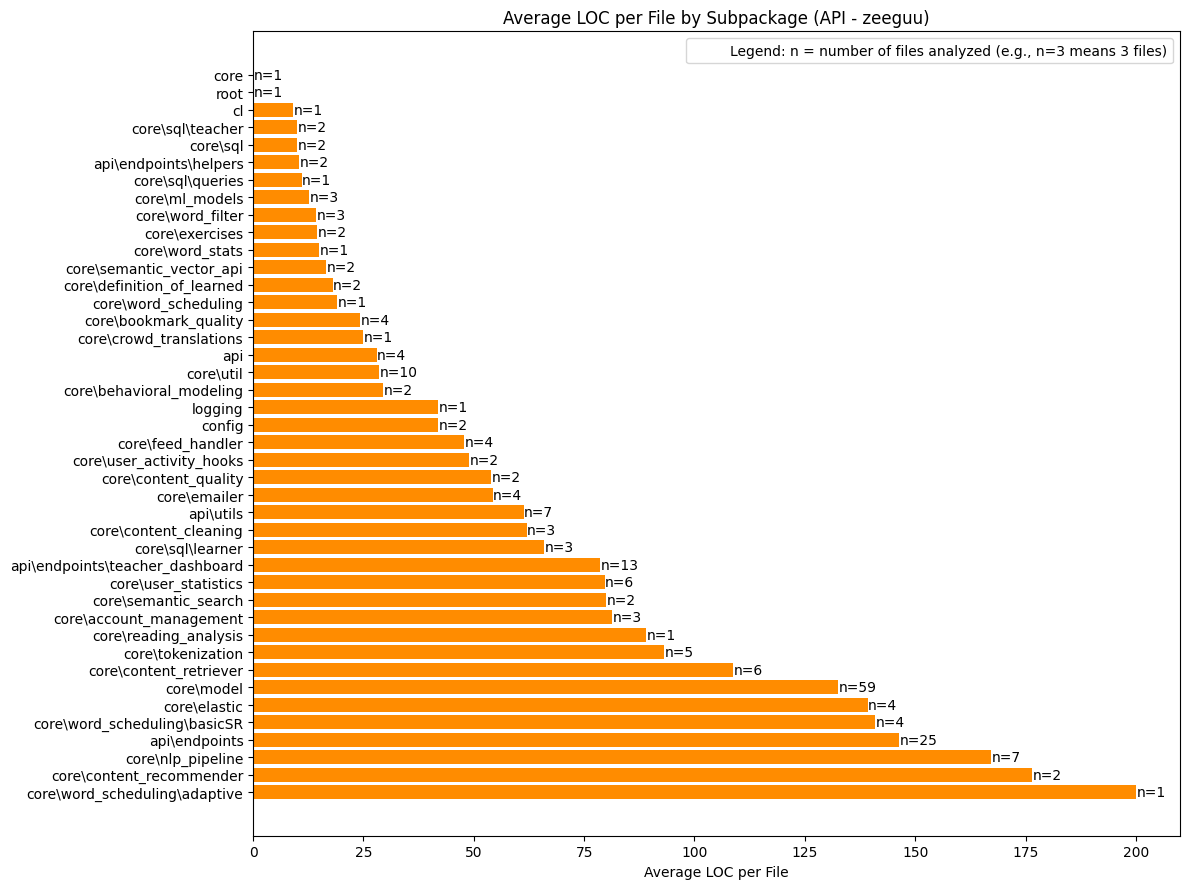

Running analysis for: tools (Directory: c:\Users\jgrum\Documents\Programming\ArchitecturalRecovery\Data\api\tools)


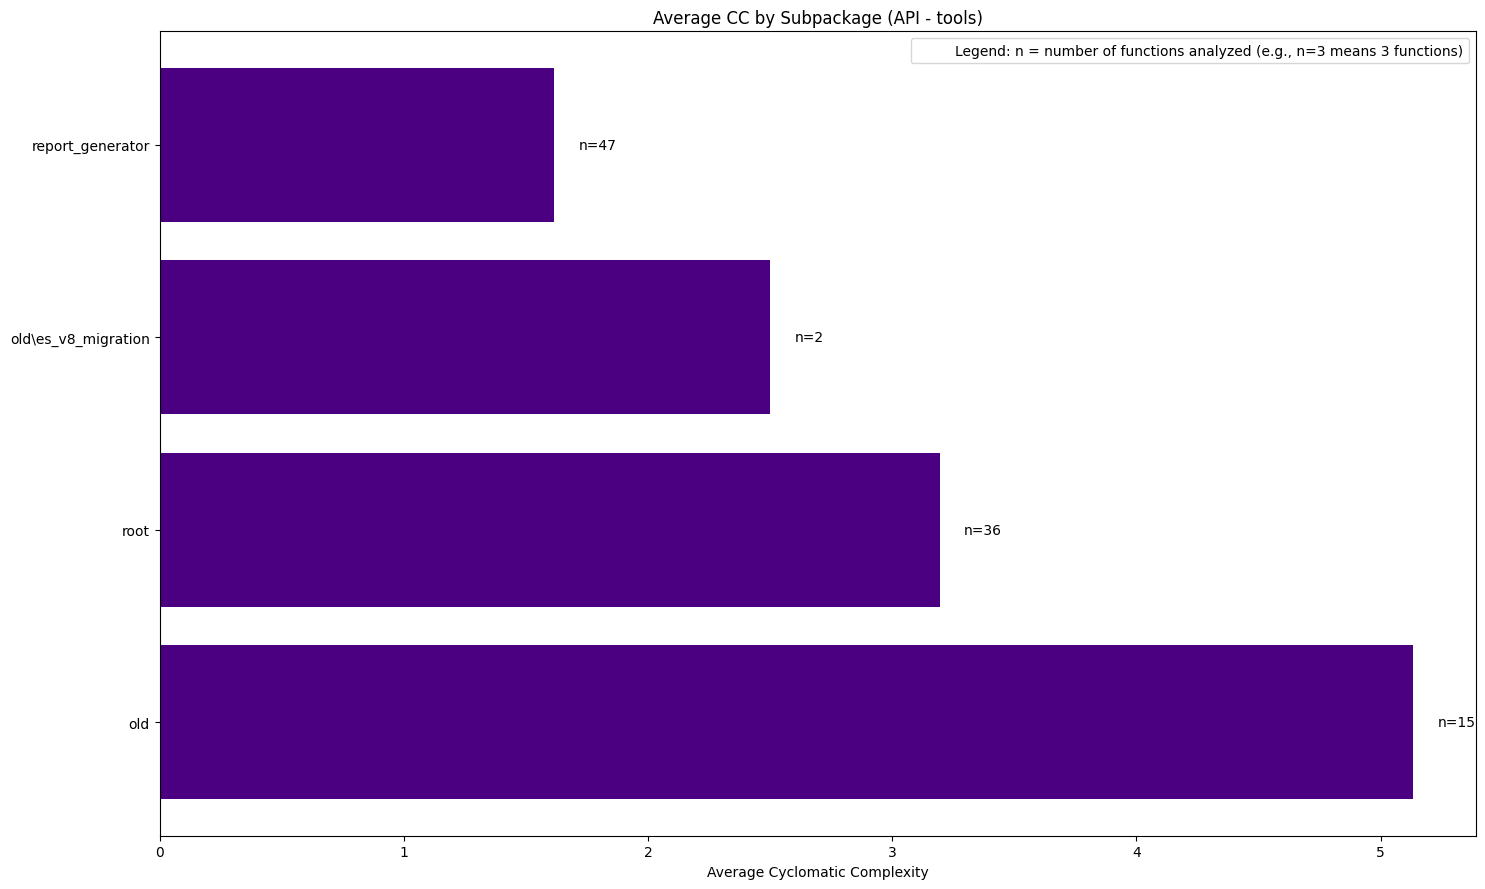

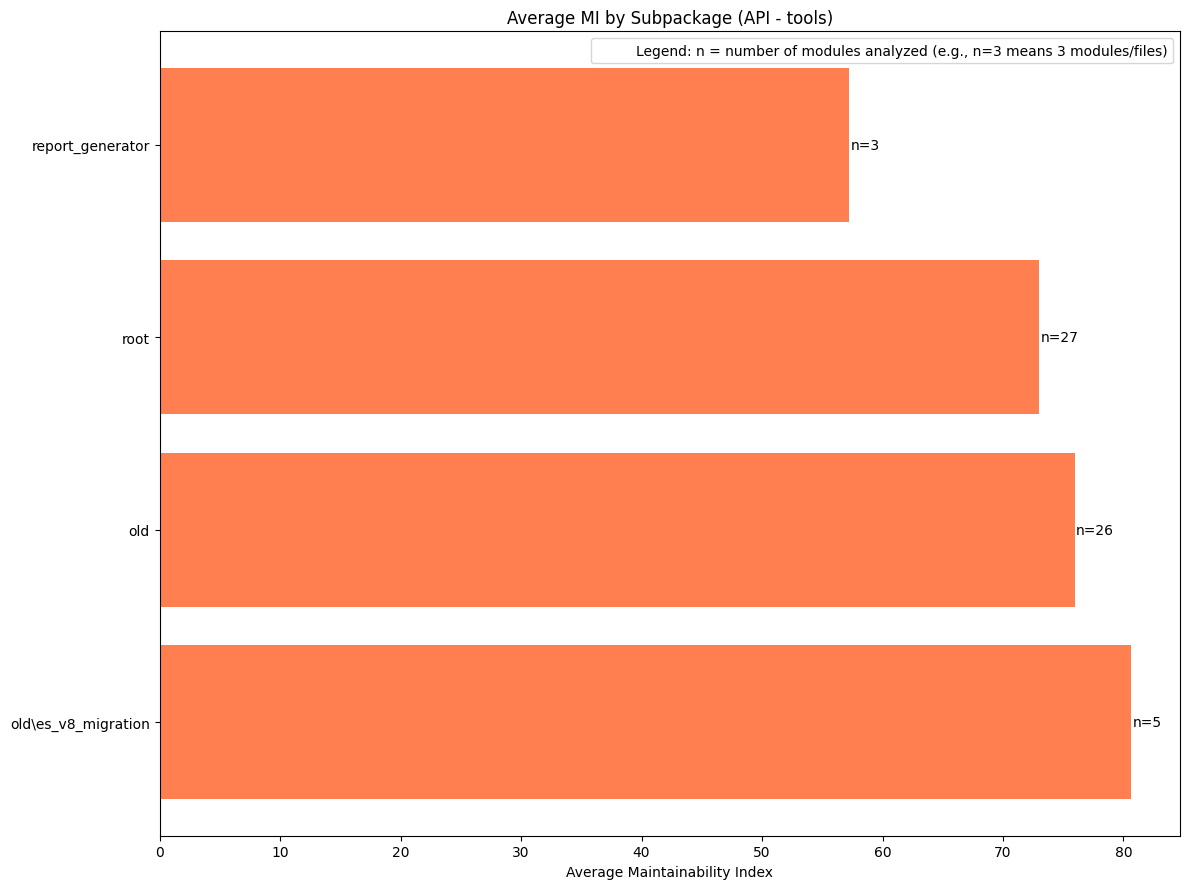

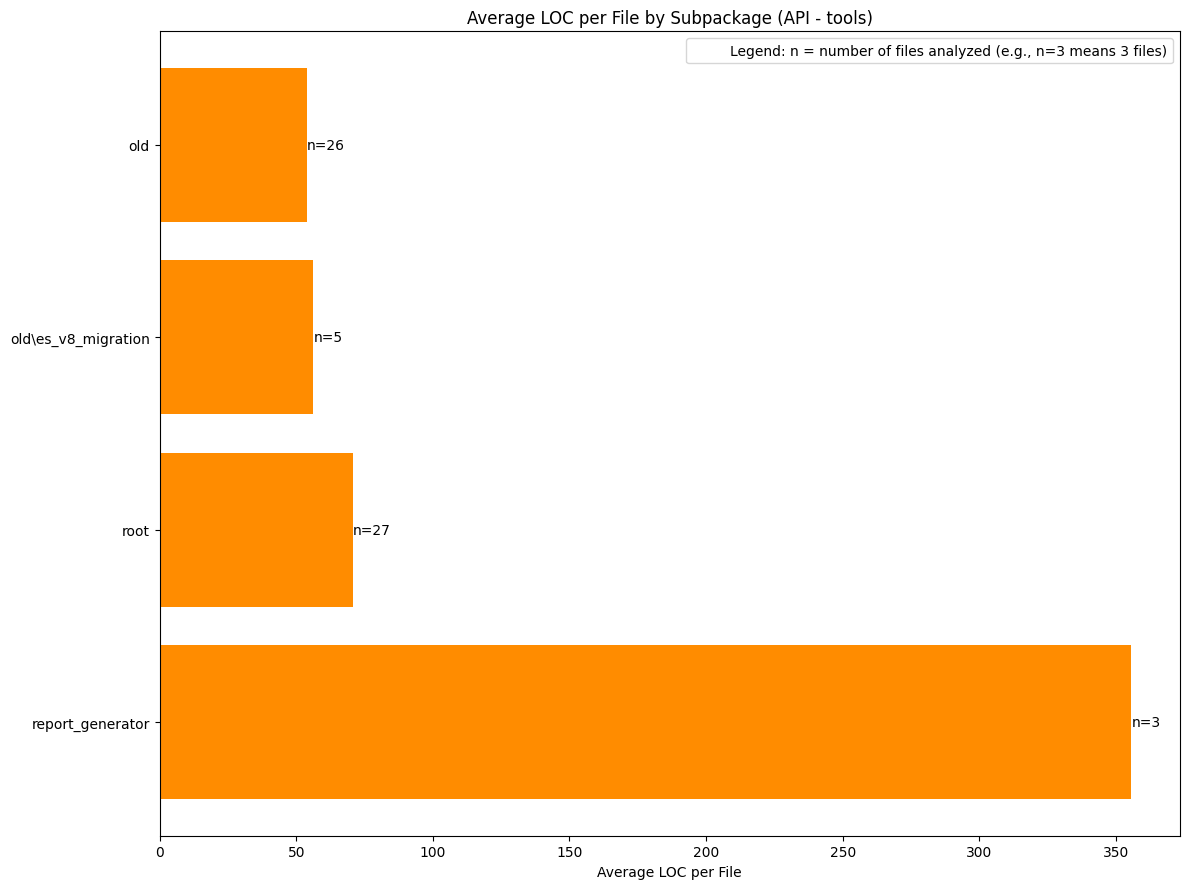

In [20]:
def aggregate_cc_by_subpackage(base_dir):
    """Aggregate Cyclomatic Complexity (CC) per subpackage using radon cc."""
    cmd = [sys.executable, "-m", "radon", "cc", base_dir, "-j", "-s", "-a"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    pkg_data = defaultdict(list)
    for filepath, funcs in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        pkg = os.path.dirname(relpath)
        if pkg == "":
            pkg = "root"
        for func in funcs:
            pkg_data[pkg].append(func["complexity"])
    return pkg_data

def aggregate_mi_by_subpackage(base_dir):
    """Aggregate Maintainability Index (MI) per subpackage using radon mi."""
    cmd = [sys.executable, "-m", "radon", "mi", base_dir, "-j"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    pkg_data = defaultdict(list)
    for filepath, mi_value in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        pkg = os.path.dirname(relpath)
        if pkg == "":
            pkg = "root"
        if isinstance(mi_value, dict):
            pkg_data[pkg].append(mi_value.get("mi", 0))
        else:
            pkg_data[pkg].append(mi_value)
    return pkg_data

def aggregate_raw_by_subpackage(base_dir):
    """Aggregate raw metrics (e.g., LOC) per subpackage using radon raw."""
    cmd = [sys.executable, "-m", "radon", "raw", base_dir, "-j", "-s"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    metrics = ["loc", "lloc", "sloc", "comments", "single_comments", "multi", "blank"]
    pkg_totals = defaultdict(lambda: {metric: 0 for metric in metrics})
    pkg_file_count = defaultdict(int)
    for filepath, stats in data.items():
        relpath = os.path.relpath(filepath, base_dir)
        pkg = os.path.dirname(relpath)
        if pkg == "":
            pkg = "root"
        pkg_file_count[pkg] += 1
        for metric in metrics:
            pkg_totals[pkg][metric] += stats.get(metric, 0)
    return pkg_totals, pkg_file_count

def sort_metric(pkg_names, metric_values, reverse=True):
    """Sort two parallel lists by metric_values.
       Set reverse=True for descending order or False for ascending."""
    sorted_pairs = sorted(zip(pkg_names, metric_values), key=lambda x: x[1], reverse=reverse)
    return zip(*sorted_pairs)  # returns (sorted_names, sorted_values)


if __name__ == "__main__":
    # Define analysis targets as tuples: (label, directory)
    analysis_targets = [
        ("zeeguu", API_ZEEGUU_DIR),
        ("tools", API_TOOLS_DIR)
    ]
    
    for label, analysis_dir in analysis_targets:
        print(f"Running analysis for: {label} (Directory: {analysis_dir})")
        
        # ---- Cyclomatic Complexity (CC) by Subpackage ----
        cc_subpkg = aggregate_cc_by_subpackage(analysis_dir)
        subpkg_names = list(cc_subpkg.keys())
        avg_cc = [sum(cc_subpkg[p]) / len(cc_subpkg[p]) if cc_subpkg[p] else 0 for p in subpkg_names]
        
        # Sort by average CC (descending order)
        sorted_names_cc, sorted_avg_cc = sort_metric(subpkg_names, avg_cc, reverse=True)
        
        plt.figure(figsize=(15, 9))
        bars = plt.barh(list(sorted_names_cc), list(sorted_avg_cc), color='indigo')
        plt.xlabel("Average Cyclomatic Complexity")
        plt.title(f"Average CC by Subpackage (API - {label})")
        for bar, pkg in zip(bars, sorted_names_cc):
            count = len(cc_subpkg[pkg])
            plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                     f"n={count}", va='center', fontsize=10)
        # Add Legend for CC Plot (explanation for n)
        legend_cc = mpatches.Patch(color='none',
                                   label="Legend: n = number of functions analyzed (e.g., n=3 means 3 functions)")
        plt.legend(handles=[legend_cc], loc='upper right', frameon=True)
        plt.tight_layout()
        cc_filename = os.path.join(RADON_OUTPUT_DIR, f'average_cc_by_subpackage_{label}.png')
        plt.savefig(cc_filename)
        plt.show()

        # ---- Maintainability Index (MI) by Subpackage ----
        mi_subpkg = aggregate_mi_by_subpackage(analysis_dir)
        subpkg_names_mi = list(mi_subpkg.keys())
        avg_mi = [sum(mi_subpkg[p]) / len(mi_subpkg[p]) if mi_subpkg[p] else 0 for p in subpkg_names_mi]
        
        # Sort by average MI (descending order)
        sorted_names_mi, sorted_avg_mi = sort_metric(subpkg_names_mi, avg_mi, reverse=True)
        
        plt.figure(figsize=(12, 9))
        bars = plt.barh(list(sorted_names_mi), list(sorted_avg_mi), color='coral')
        plt.xlabel("Average Maintainability Index")
        plt.title(f"Average MI by Subpackage (API - {label})")
        for bar, pkg in zip(bars, sorted_names_mi):
            count = len(mi_subpkg[pkg])
            plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                     f"n={count}", va='center', fontsize=10)
        # Add Legend for MI Plot
        legend_mi = mpatches.Patch(color='none',
                                   label="Legend: n = number of modules analyzed (e.g., n=3 means 3 modules/files)")
        plt.legend(handles=[legend_mi], loc='upper right', frameon=True)
        plt.tight_layout()
        mi_filename = os.path.join(RADON_OUTPUT_DIR, f'average_mi_by_subpackage_{label}.png')
        plt.savefig(mi_filename)
        plt.show()

        # ---- Raw Metrics (using LOC as an example) by Subpackage ----
        raw_subpkg, subpkg_file_count = aggregate_raw_by_subpackage(analysis_dir)
        subpkg_names_raw = list(raw_subpkg.keys())
        avg_loc = [raw_subpkg[p]['loc'] / subpkg_file_count[p] if subpkg_file_count[p] else 0 for p in subpkg_names_raw]
        
        # Sort by average LOC (descending order)
        sorted_names_loc, sorted_avg_loc = sort_metric(subpkg_names_raw, avg_loc, reverse=True)
        
        plt.figure(figsize=(12, 9))
        bars = plt.barh(list(sorted_names_loc), list(sorted_avg_loc), color='darkorange')
        plt.xlabel("Average LOC per File")
        plt.title(f"Average LOC per File by Subpackage (API - {label})")
        for bar, pkg in zip(bars, sorted_names_loc):
            count = subpkg_file_count[pkg]
            plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                     f"n={count}", va='center', fontsize=10)
        # Add Legend for LOC Plot
        legend_loc = mpatches.Patch(color='none',
                                    label="Legend: n = number of files analyzed (e.g., n=3 means 3 files)")
        plt.legend(handles=[legend_loc], loc='upper right', frameon=True)
        plt.tight_layout()
        raw_filename = os.path.join(RADON_OUTPUT_DIR, f'average_loc_by_subpackage_{label}.png')
        plt.savefig(raw_filename)
        plt.show()

### Intermediate analysis

Kinda funny, but here we can see a package called "old", being a relative small package which also have a very high CC, most likely because it has been identified as a weak point and is being slowly refactored away.

We also notice that most files are placed directly in the root of tools, whereas for the zeeguu project, it is placed in various subdirectories under the zeeguu project. This need for more components is also indicated by the huge size of the zeeguu directory, as to increase the maintainability.



### Trying to identify weak-spots

By sorting the whole project based on the metrics shown thus far:

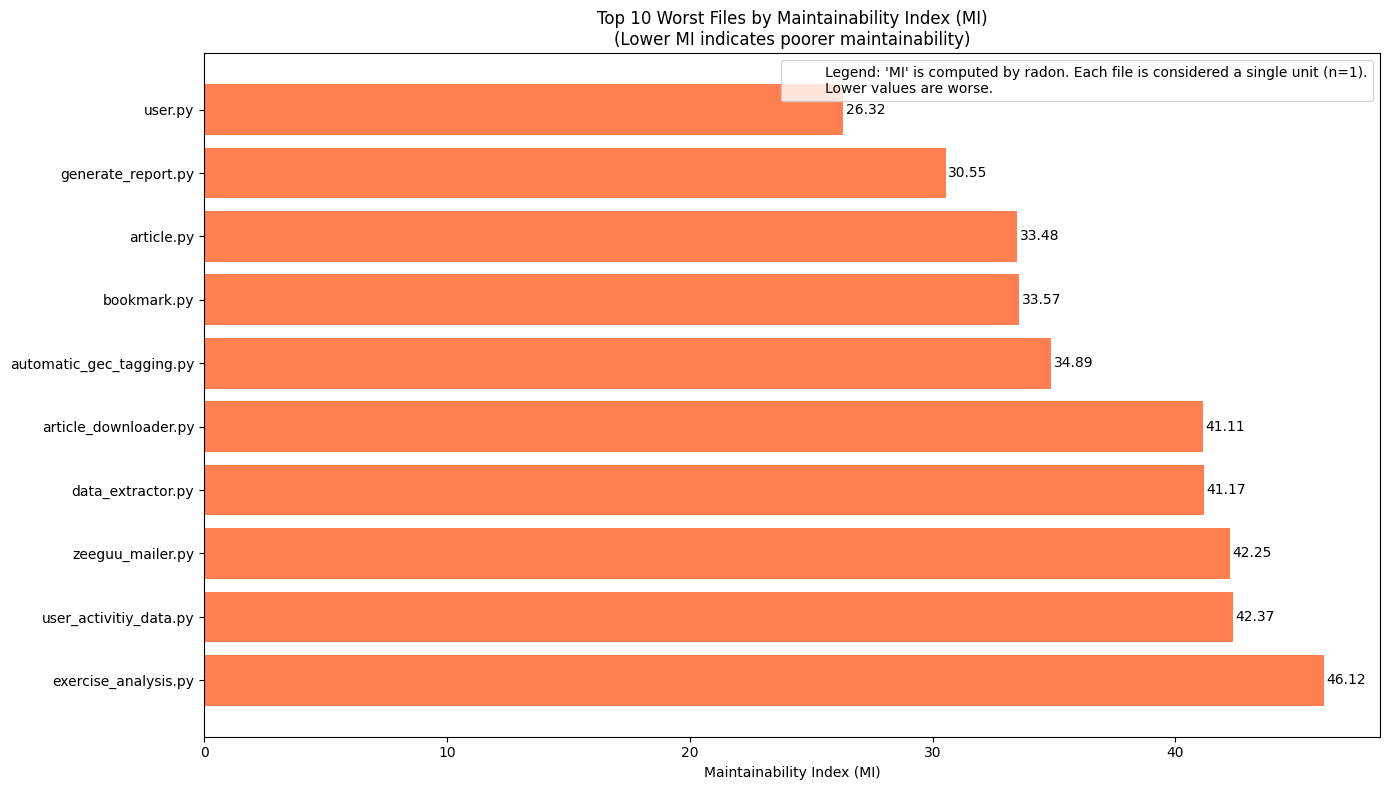

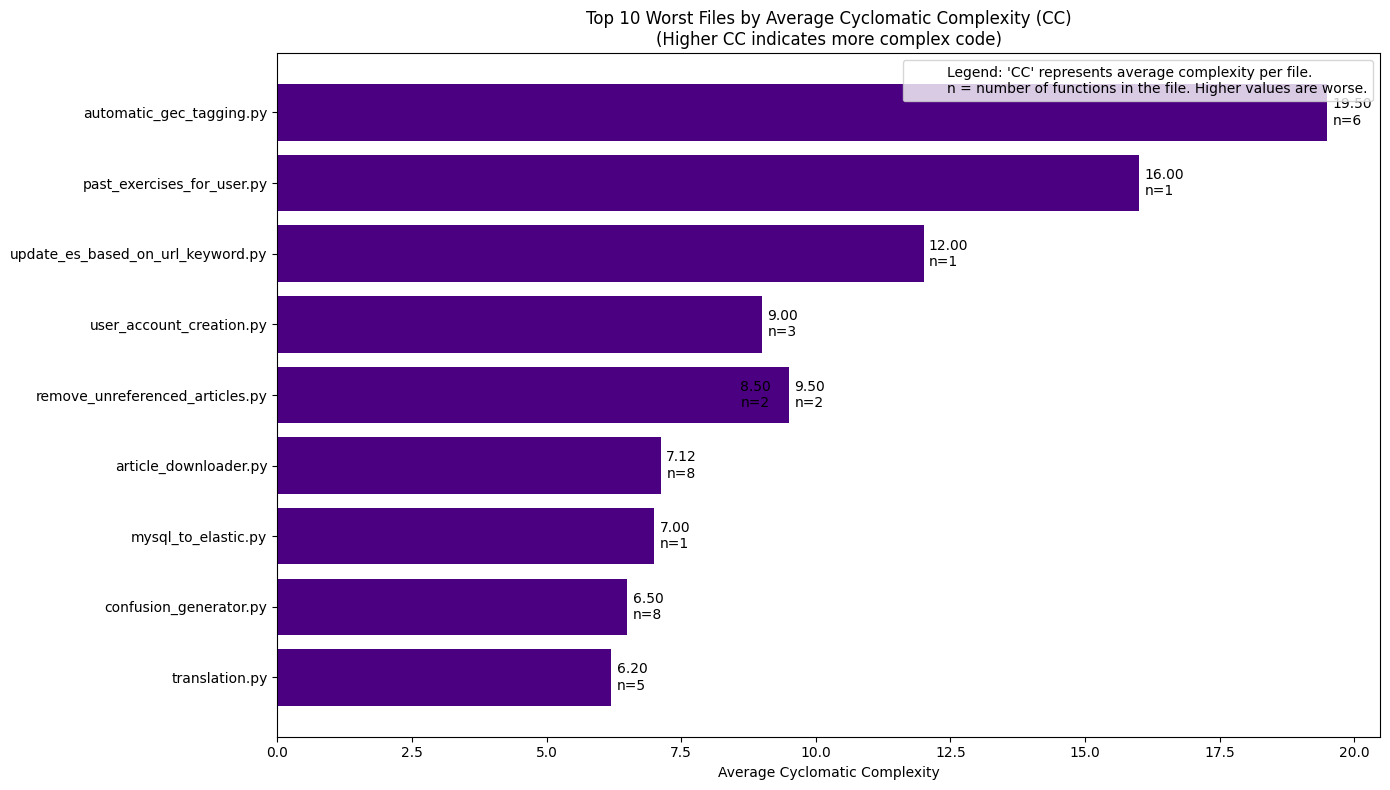

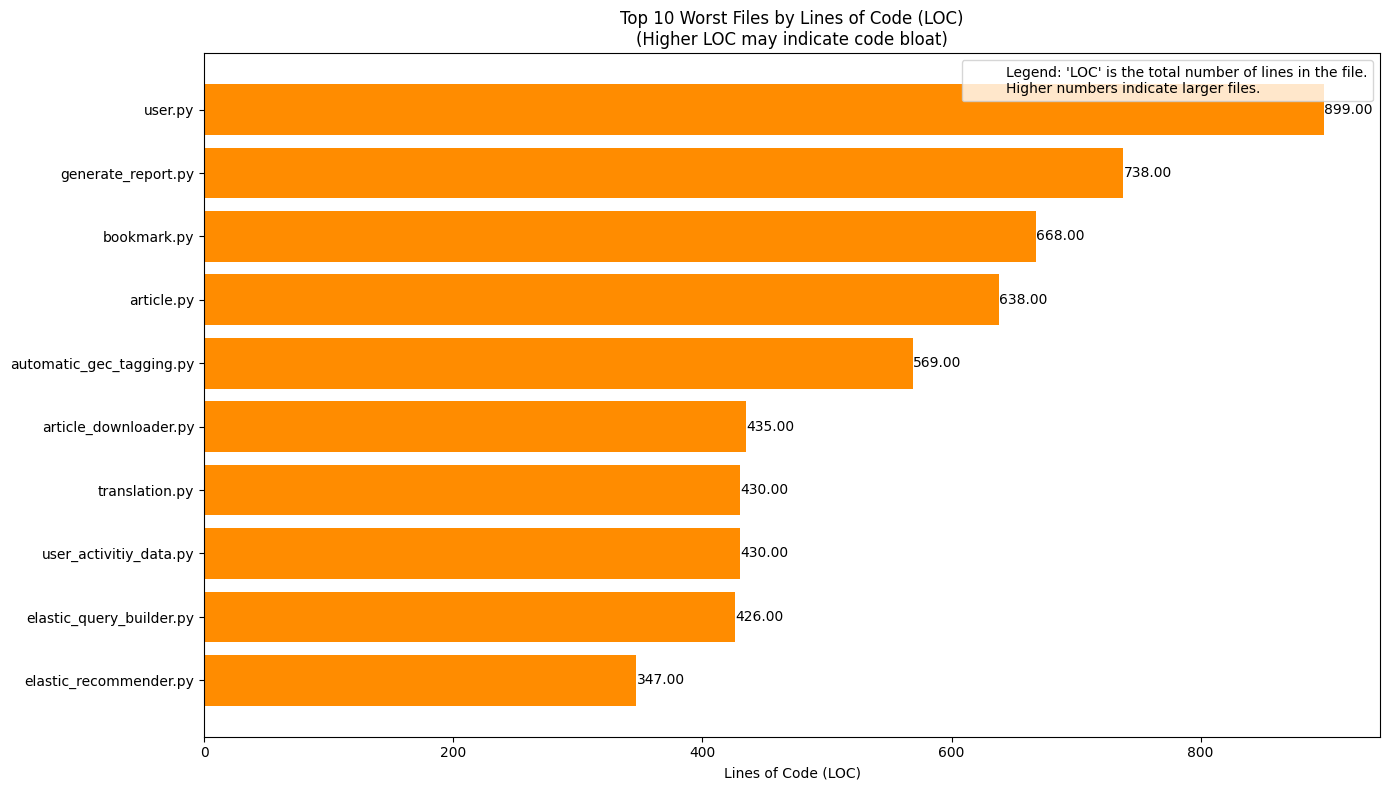

In [21]:
import os
import sys
import json
import subprocess
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# -------------------------
# Directory Setup
# -------------------------
# Expected current working directory: ...\Tools
TOOLS_DIR = os.getcwd()  # e.g., C:\Programming\Architecture\ArchitecturalRecovery\Tools
BASE_DIR = os.path.abspath(os.path.join(TOOLS_DIR, '..'))  # Project root: C:\Programming\Architecture\ArchitecturalRecovery

# Data directory (note: folder names are case-sensitive on some platforms)
DATA_DIR = os.path.join(BASE_DIR, 'Data')

# API_DIR for the whole API project (the root where the solution lives)
API_DIR = os.path.join(DATA_DIR, 'api')

# Set the output directory to match:
# ProjectRoot\Output\radon
OUTPUT_DIR = os.path.join(BASE_DIR, 'Output')
RADON_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'radon')
os.makedirs(RADON_OUTPUT_DIR, exist_ok=True)

# -------------------------
# File-Level Analysis Functions
# -------------------------
def get_worst_mi_files(base_dir, top=10):
    """
    Run 'radon mi' on base_dir and return a list of tuples (filepath, mi)
    sorted in ascending order (lowest MI is worst). Reverse so that the worst
    appears at the top of the horizontal bar chart.
    """
    cmd = [sys.executable, "-m", "radon", "mi", base_dir, "-j"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    file_mi = {}
    for filepath, mi in data.items():
        try:
            mi_val = mi["mi"] if isinstance(mi, dict) else mi
        except Exception:
            mi_val = 0
        file_mi[filepath] = mi_val
    worst = sorted(file_mi.items(), key=lambda x: x[1])[:top]
    return worst[::-1]

def get_worst_cc_files(base_dir, top=10):
    """
    Run 'radon cc' on base_dir and compute average cyclomatic complexity per file,
    also recording the number of functions in each file.
    Return a list of tuples (filepath, avg_cc, count) sorted in descending order (highest CC is worst),
    then reversed for plotting (so the worst file appears at the top).
    """
    cmd = [sys.executable, "-m", "radon", "cc", base_dir, "-j", "-s", "-a"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    file_cc = {}
    file_cc_count = {}
    for filepath, funcs in data.items():
        if funcs:
            avg_cc = sum(func["complexity"] for func in funcs) / len(funcs)
            count = len(funcs)
        else:
            avg_cc = 0
            count = 0
        file_cc[filepath] = avg_cc
        file_cc_count[filepath] = count
    worst = sorted(file_cc.items(), key=lambda x: x[1], reverse=True)[:top]
    worst_with_counts = [(fp, file_cc[fp], file_cc_count[fp]) for fp, _ in worst]
    return worst_with_counts[::-1]

def get_worst_loc_files(base_dir, top=10):
    """
    Run 'radon raw' on base_dir and extract the total LOC per file.
    Return a list of tuples (filepath, loc) sorted in descending order (highest LOC is worst),
    then reversed for plotting.
    """
    cmd = [sys.executable, "-m", "radon", "raw", base_dir, "-j", "-s"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    data = json.loads(result.stdout)
    file_loc = {}
    for filepath, stats in data.items():
        loc = stats.get("loc", 0)
        file_loc[filepath] = loc
    worst = sorted(file_loc.items(), key=lambda x: x[1], reverse=True)[:top]
    return worst[::-1]

# -------------------------
# Plotting Helper Function
# -------------------------
def plot_metric(metric_data, metric_label, title, legend_text, save_filename, bar_color):
    """
    Plot a horizontal bar chart for the given metric data.
    metric_data: list of tuples. For MI and LOC: (filepath, value).
                 For CC: (filepath, value, count).
    If the tuple has three elements, the annotation will combine the metric value and the count (using a newline).
    """
    if not metric_data:
        print("No metric data to plot.")
        return

    # Check tuple length to determine annotation type
    tuple_length = len(metric_data[0])
    if tuple_length == 2:
        file_names, values = zip(*metric_data)
        annotations = [f"{v:.2f}" for v in values]
    elif tuple_length == 3:
        file_names, values, counts = zip(*metric_data)
        annotations = [f"{v:.2f}\nn={c}" for v, c in zip(values, counts)]
    else:
        raise ValueError("Unexpected tuple length in metric data.")

    # Display only the basename for clarity
    display_names = [os.path.basename(name) for name in file_names]

    plt.figure(figsize=(14, 8))
    bars = plt.barh(display_names, values, color=bar_color)
    plt.xlabel(metric_label)
    plt.title(title)

    # Annotate bars with metric value and (if applicable) count.
    for bar, label in zip(bars, annotations):
        plt.text(bar.get_width() + 0.1, 
                 bar.get_y() + bar.get_height() / 2,
                 label, va='center', fontsize=10)

    # Add a legend in the upper right corner.
    legend_patch = mpatches.Patch(color='none', label=legend_text)
    plt.legend(handles=[legend_patch], loc='upper right', frameon=True)

    plt.tight_layout()
    plt.savefig(save_filename)
    plt.show()

# -------------------------
# Main Execution: Whole-Project Analysis (API_DIR)
# -------------------------
if __name__ == "__main__":
    # Use the entire API project directory.
    analysis_dir = API_DIR

    # -- Worst Files by Maintainability Index (MI) --
    worst_mi = get_worst_mi_files(analysis_dir, top=10)
    mi_plot_title = ("Top 10 Worst Files by Maintainability Index (MI)\n"
                     "(Lower MI indicates poorer maintainability)")
    mi_legend = ("Legend: 'MI' is computed by radon. Each file is considered a single unit (n=1).\n"
                 "Lower values are worse.")
    mi_filename = os.path.join(RADON_OUTPUT_DIR, 'worst_mi_files.png')
    plot_metric(worst_mi,
                metric_label="Maintainability Index (MI)",
                title=mi_plot_title,
                legend_text=mi_legend,
                save_filename=mi_filename,
                bar_color="coral")

    # -- Worst Files by Cyclomatic Complexity (CC) --
    worst_cc = get_worst_cc_files(analysis_dir, top=10)
    cc_plot_title = ("Top 10 Worst Files by Average Cyclomatic Complexity (CC)\n"
                     "(Higher CC indicates more complex code)")
    cc_legend = ("Legend: 'CC' represents average complexity per file.\n"
                 "n = number of functions in the file. Higher values are worse.")
    cc_filename = os.path.join(RADON_OUTPUT_DIR, 'worst_cc_files.png')
    plot_metric(worst_cc,
                metric_label="Average Cyclomatic Complexity",
                title=cc_plot_title,
                legend_text=cc_legend,
                save_filename=cc_filename,
                bar_color="indigo")

    # -- Worst Files by Lines of Code (LOC) --
    worst_loc = get_worst_loc_files(analysis_dir, top=10)
    loc_plot_title = ("Top 10 Worst Files by Lines of Code (LOC)\n"
                      "(Higher LOC may indicate code bloat)")
    loc_legend = ("Legend: 'LOC' is the total number of lines in the file.\n"
                  "Higher numbers indicate larger files.")
    loc_filename = os.path.join(RADON_OUTPUT_DIR, 'worst_loc_files.png')
    plot_metric(worst_loc,
                metric_label="Lines of Code (LOC)",
                title=loc_plot_title,
                legend_text=loc_legend,
                save_filename=loc_filename,
                bar_color="darkorange")


### Intermediate Analysis

While this might show weak-spots, it is also more likely that this also simply shows where most things are happening.
Such as the generate_report.py might have low maintainability and high lines of code, but it might also be a deep-module, which performs a lot of actions, compared to the narrowness of its interface.

We might get more of a indication of this, by looking at which modules calls/depends on what.

### Visualizing dependencies

In [35]:
import os
import sys
import json
import subprocess
import ast
from pathlib import Path
import math
import ast


import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from collections import defaultdict

# ------------------------------------------------------------------
# Directory Setup
# ------------------------------------------------------------------
TOOLS_DIR        = os.getcwd()
BASE_DIR         = os.path.abspath(os.path.join(TOOLS_DIR, '..'))
DATA_DIR         = os.path.join(BASE_DIR, 'Data')
API_DIR          = os.path.join(DATA_DIR, 'api')
API_ZEEGUU_DIR   = os.path.join(API_DIR, 'zeeguu')
API_TOOLS_DIR    = os.path.join(API_DIR, 'tools')
OUTPUT_DIR       = os.path.join(BASE_DIR, 'Output')
RADON_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'radon')

os.makedirs(RADON_OUTPUT_DIR, exist_ok=True)

# ------------------------------------------------------------------
# 1) Gather detailed complexity from Radon
# ------------------------------------------------------------------
def get_detailed_complexity(directory):
    result = subprocess.run(
        [sys.executable, "-m", "radon", "cc", directory, "-j"],
        capture_output=True, text=True
    )
    try:
        data = json.loads(result.stdout)
    except json.JSONDecodeError:
        print(f"Error parsing JSON output from radon for {directory}")
        return {}
    
    module_data = {}
    base_path = Path(directory).resolve()
    for file_str, funcs in data.items():
        file_path = Path(file_str).resolve()
        if not file_path.is_file():
            continue
        try:
            rel = file_path.relative_to(base_path)
        except ValueError:
            continue
        
        parts = list(rel.parts)
        if parts[-1] == "__init__.py":
            module = ".".join(parts[:-1])
        else:
            parts[-1] = parts[-1][:-3]
            module = ".".join(parts)
        if not module or module.startswith("_"):
            continue
        
        module_data.setdefault(module, [])
        for f in funcs:
            module_data[module].append({
                "name": f["name"],
                "complexity": f["complexity"],
                "rank": f["rank"]
            })
    return module_data

# ------------------------------------------------------------------
# 2) Filter out less important data
# ------------------------------------------------------------------
def filter_detailed_data(module_data,
                         min_functions=1,
                         min_avg_complexity=0,
                         top_modules=None,
                         min_func_complexity=0,
                         top_functions=5):
    filtered = {}
    # drop low‐complexity funcs
    for mod, funcs in module_data.items():
        good = [f for f in funcs if f["complexity"] >= min_func_complexity]
        if good:
            filtered[mod] = good

    # drop small modules or low avg CC
    for mod in list(filtered):
        funcs = filtered[mod]
        if len(funcs) < min_functions:
            del filtered[mod]
            continue
        avg = sum(f["complexity"] for f in funcs) / len(funcs)
        if avg < min_avg_complexity:
            del filtered[mod]

    # keep top modules by avg CC
    if top_modules:
        sorted_mods = sorted(
            filtered.items(),
            key=lambda kv: sum(f["complexity"] for f in kv[1]) / len(kv[1]),
            reverse=True
        )
        filtered = dict(sorted_mods[:top_modules])

    # keep top functions per module
    if top_functions:
        for mod in filtered:
            filtered[mod] = sorted(
                filtered[mod],
                key=lambda x: x["complexity"],
                reverse=True
            )[:top_functions]

    return filtered

# ------------------------------------------------------------------
# New function to create a separate legend figure
# ------------------------------------------------------------------
def create_legend_figure(output_dir, fontsize=10):
    # complexity‐rank → color map
    rank_colors = {
        "A":"green","B":"orange","C":"red",
        "D":"darkred","E":"purple","F":"black"
    }
    # detailed descriptions for legend
    rank_descriptions = {
        "A": "low risk - simple block",
        "B": "low risk - well structured and stable block",
        "C": "moderate risk - slightly complex block",
        "D": "more than moderate risk - more complex block",
        "E": "high risk - complex block, alarming",
        "F": "very high risk - error-prone, unstable block"
    }
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Create legend handles
    handles = [
        Line2D([0],[0], linestyle="None", label="Node Types:", markersize=14),
        Line2D([0],[0], marker="o", color="w", label="Root",   markerfacecolor="blue",  markersize=8),
        Line2D([0],[0], marker="o", color="w", label="Module", markerfacecolor="gray",  markersize=8),
        Line2D([0],[0], marker="s", color="w", label="Function", markerfacecolor="gray", markersize=8),
        Line2D([0],[0], linestyle="None", label="", markersize=8),  # Empty spacer for better separation
        Line2D([0],[0], linestyle="None", label="CC Ranks:", markersize=14),
    ]
    for rank, col in rank_colors.items():
        desc = rank_descriptions.get(rank, "")
        handles.append(
            Line2D([0],[0], marker="s", color="w",
                   label=f"{rank} ({desc})",
                   markerfacecolor=col, markersize=8)
        )
    
    # Create legend
    legend = ax.legend(
        handles=handles, 
        loc="center", 
        fontsize=fontsize,
        framealpha=0.95,
        borderaxespad=0.5,
        labelspacing=1.2,
        ncol=1,
        handletextpad=1.5
    )
    legend.get_frame().set_linewidth(1)
    legend.get_frame().set_facecolor('white')
    
    # Remove axes
    ax.axis('off')
    
    # Set title
    fig.suptitle("Code Complexity Visualization Legend", fontsize=fontsize+4, y=0.98)
    
    # Save figure
    os.makedirs(output_dir, exist_ok=True)
    fname = os.path.join(output_dir, "complexity_legend.png")
    plt.savefig(fname, dpi=300, bbox_inches="tight")
    plt.close(fig)
    
    return fname

# ------------------------------------------------------------------
# 3) Create hierarchy visualization (modified to not include legend)
# ------------------------------------------------------------------
import os
import math
import random
import ast
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

def create_hierarchy_view(detailed_data, title, output_dir, source_dir, filters=None, fontsize=10):
    if not detailed_data:
        print(f"No data for {title}")
        return

    # complexity‐rank → color map
    rank_colors = {
        "A":"green","B":"orange","C":"red",
        "D":"darkred","E":"purple","F":"black"
    }

    def avg_rank(funcs):
        avg = sum(f["complexity"] for f in funcs) / len(funcs)
        if   avg <=  5: return "A"
        elif avg <= 10: return "B"
        elif avg <= 20: return "C"
        elif avg <= 30: return "D"
        elif avg <= 40: return "E"
        else:            return "F"

    # build DiGraph
    G = nx.DiGraph()
    G.add_node(title, type="root", rank="A")
    for mod, funcs in detailed_data.items():
        G.add_node(mod, type="module", rank=avg_rank(funcs))
        G.add_edge(title, mod)
        for f in funcs:
            node = f"{mod}.{f['name']}"
            G.add_node(node, type="function", rank=f["rank"])
            G.add_edge(mod, node)

    # initial layout (Graphviz or spring)
    try:
        A = nx.nx_agraph.to_agraph(G)
        A.graph_attr.update(overlap='false', sep='+0.8', nodesep='0.7', ranksep='1.0')
        A.layout(prog='dot')
        pos = { n.get_name(): tuple(map(float, n.attr['pos'].split(','))) for n in A.nodes() }
    except Exception:
        pos = nx.spring_layout(G, k=1.5, iterations=700, scale=3.0)

    # stretch vertically & compress horizontally
    for k in pos:
        x,y = pos[k]
        pos[k] = (x * 0.7, y * 3.0)

    # compute LOC & params
    locs, params = {}, {}
    src_root = Path(source_dir)
    for mod, funcs in detailed_data.items():
        p = src_root.joinpath(*mod.split('.')).with_suffix('.py')
        if p.is_file():
            lines = p.read_text(errors='ignore').splitlines()
            locs[mod] = sum(1 for L in lines if L.strip() and not L.strip().startswith('#'))
            tree = ast.parse("\n".join(lines))
            for node in tree.body:
                if isinstance(node, ast.FunctionDef):
                    full = f"{mod}.{node.name}"
                    locs[full] = (node.end_lineno - node.lineno + 1) if hasattr(node, 'end_lineno') else 0
                    cnt = len(node.args.args) + len(node.args.kwonlyargs)
                    if node.args.vararg: cnt += 1
                    if node.args.kwarg:  cnt += 1
                    params[full] = cnt
        else:
            locs[mod] = 0
            for f in funcs:
                full = f"{mod}.{f['name']}"
                locs[full] = 0
                params[full] = 0

    # normalize LOC → node_sizes (points²)
    all_locs = list(locs.values()) or [0,1]
    lm, lM = min(all_locs), max(all_locs)
    smin, smax = 500 * 0.4, 500 * 3.5
    node_sizes = [
        (smin + (loc - lm)/(lM - lm)*(smax - smin)) if lM>lm else (smin+smax)/2
        for loc in (locs.get(n, lm) for n in G.nodes())
    ]

    # — MANUAL OVERLAP AVOIDANCE (rectangular) —
    fig, ax = plt.subplots(figsize=(16,20))
    nodes = list(G.nodes())
    # data→display transform
    disp_pos = {n: ax.transData.transform(pos[n]) for n in nodes}
    px_per_pt = fig.dpi / 72.0
    radii = {
        n: (math.sqrt(node_sizes[i]) / 2.0) * px_per_pt
        for i,n in enumerate(nodes)
    }
    pad_px = 2.0

    # 200 iterations instead of 50
    for _ in range(200):
        moved = False
        for i, ni in enumerate(nodes):
            xi, yi = disp_pos[ni]
            ri = radii[ni]
            for nj in nodes[i+1:]:
                xj, yj = disp_pos[nj]
                rj = radii[nj]
                dx, dy = xj - xi, yj - yi
                min_sep = ri + rj + pad_px
                # if bounding‐boxes overlap on both axes
                if abs(dx) < min_sep and abs(dy) < min_sep:
                    # how much to shift each
                    overlap_x = (min_sep - abs(dx)) * 0.5 if abs(dx)>0 else min_sep*0.5
                    overlap_y = (min_sep - abs(dy)) * 0.5 if abs(dy)>0 else min_sep*0.5
                    sign_x = dx/abs(dx) if abs(dx)>0 else random.choice([-1,1])
                    sign_y = dy/abs(dy) if abs(dy)>0 else random.choice([-1,1])

                    disp_pos[ni] = (xi - sign_x * overlap_x,
                                    yi - sign_y * overlap_y)
                    disp_pos[nj] = (xj + sign_x * overlap_x,
                                    yj + sign_y * overlap_y)
                    xi, yi = disp_pos[ni]
                    moved = True
        if not moved:
            break

    # back to data coords
    for n in nodes:
        pos[n] = ax.transData.inverted().transform(disp_pos[n])
    plt.close(fig)

    # normalize edges → widths 
    em = []
    for u,v in G.edges():
        em.append(len(detailed_data[v]) if u==title else params.get(v,0))
    mmin, mmax = (min(em),max(em)) if em else (0,1)
    wmin, wmax = 1, 5.0
    edge_widths = [
        (wmin + (m-mmin)/(mmax-mmin)*(wmax-wmin)) if mmax>mmin else (wmin+wmax)/2
        for m in em
    ]

    # —— DRAW —— 
    fig, ax = plt.subplots(figsize=(16,20))
    plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.05)
    fig.suptitle(f"{title} Module-Function Hierarchy",
                 fontsize=fontsize+8, x=0.01, ha="left", y=0.98)

    base_fs = fontsize - 1
    scale = filters.get('label_scale', 1.0) if filters else 1.0

    # filters legend
    if filters:
        labels = {
            "min_functions":"Min number of functions",
            "min_avg_complexity":"Min avg CC for module",
            "top_modules":"Top CC modules",
            "min_func_complexity":"Min CC for functions",
            "top_functions":"Top CC functions"
        }
        txt = "Filters Applied:\n"
        for k,v in filters.items():
            if k!='label_scale':
                txt += f"• {labels.get(k,k)}: {v}\n"
        fig.text(0.01, 0.94, txt, va="top", ha="left",
                 fontsize=base_fs*scale,
                 bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="black"))

    # draw nodes
    for ntype, shape in [("root","o"),("module","o"),("function","s")]:
        subset = [n for n,a in G.nodes(data=True) if a["type"]==ntype]
        sizes  = [node_sizes[nodes.index(n)] for n in subset]
        colors = ("blue" if ntype=="root"
                  else [rank_colors[G.nodes[n]["rank"]] for n in subset])
        nx.draw_networkx_nodes(G, pos,
                               nodelist=subset,
                               node_size=sizes,
                               node_color=colors,
                               alpha=0.9,
                               node_shape=shape,
                               ax=ax)

    # draw edges
    nx.draw_networkx_edges(G, pos,
                           arrows=True, arrowstyle='-|>', arrowsize=15,
                           width=edge_widths, alpha=0.6, edge_color='gray',
                           ax=ax)

    # draw labels
    for n,(x,y) in pos.items():
        ax.annotate(n, xy=(x,y),
                    xytext=(0,11), textcoords='offset points',
                    ha='center', va='bottom',
                    fontsize=base_fs*scale,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))

    ax.axis("off")

    # save
    os.makedirs(output_dir, exist_ok=True)
    fname = os.path.join(output_dir, f"{title.lower().replace(' ','_')}_hierarchy.png")
    plt.tight_layout()
    plt.savefig(fname, dpi=300, bbox_inches="tight")
    plt.close(fig)
    return fname


if __name__ == "__main__":
    # Define consistent fontsize for all figures
    FONTSIZE = 10
    
    # Create legend figure first
    legend_file = create_legend_figure(RADON_OUTPUT_DIR, fontsize=FONTSIZE)
    print(f"Legend saved to: {legend_file}")
    
    # -- Profiles for API Tools (can tune independently) --
    profiles_tools = {
        'No filtering': {
            'min_functions': 1,
            'min_avg_complexity': 0,
            'top_modules': None,
            'min_func_complexity': 0,
            'top_functions': None,
            'label_scale': 1.0
        },
        'Light filtering': {
            'min_functions': 1,
            'min_avg_complexity': 2,
            'top_modules': 15,
            'min_func_complexity': 2,
            'top_functions': 15,
            'label_scale': 1.5
        },
        'Heavy filtering': {
            'min_functions': 3,
            'min_avg_complexity': 3,
            'top_modules': 8,
            'min_func_complexity': 3,
            'top_functions': 5,
            'label_scale': 2.0
        }
    }

    profiles_zeeguu = {
        'No filtering': {
            'min_functions': 1,
            'min_avg_complexity': 0,
            'top_modules': None,
            'min_func_complexity': 0,
            'top_functions': None,
            'label_scale': 1.0
        },
        'Light filtering': {
            'min_functions': 2,
            'min_avg_complexity': 2,
            'top_modules': 10,
            'min_func_complexity': 2,
            'top_functions': 10,
            'label_scale': 1.8
        },
        'Heavy filtering': {
            'min_functions': 2,
            'min_avg_complexity': 2.5,
            'top_modules': 6,
            'min_func_complexity': 2.5,
            'top_functions': 6,
            'label_scale': 1.9
        }
    }

    # -- Render for Tools --
    tool_files = []
    for title, params in profiles_tools.items():
        raw = get_detailed_complexity(API_TOOLS_DIR)
        filt = filter_detailed_data(
            raw,
            params['min_functions'],
            params['min_avg_complexity'],
            params['top_modules'],
            params['min_func_complexity'],
            params['top_functions']
        )
        file = create_hierarchy_view(
            filt,
            f"API Tools - {title}",
            RADON_OUTPUT_DIR,
            API_TOOLS_DIR,
            filters=params,
            fontsize=FONTSIZE
        )
        tool_files.append(file)
        print(f"Created: {file}")

    # -- Render for Zeeguu --
    zeeguu_files = []
    for title, params in profiles_zeeguu.items():
        raw = get_detailed_complexity(API_ZEEGUU_DIR)
        filt = filter_detailed_data(
            raw,
            params['min_functions'],
            params['min_avg_complexity'],
            params['top_modules'],
            params['min_func_complexity'],
            params['top_functions']
        )
        file = create_hierarchy_view(
            filt,
            f"API Zeeguu - {title}",
            RADON_OUTPUT_DIR,
            API_ZEEGUU_DIR,
            filters=params,
            fontsize=FONTSIZE
        )
        zeeguu_files.append(file)
        print(f"Created: {file}")
        
    print("\nAll files generated:")
    print(f"Legend: {legend_file}")
    print("Tools:", tool_files)
    print("Zeeguu:", zeeguu_files)

Legend saved to: c:\Users\jgrum\Documents\Programming\ArchitecturalRecovery\Output\radon\complexity_legend.png
Created: c:\Users\jgrum\Documents\Programming\ArchitecturalRecovery\Output\radon\api_tools_-_no_filtering_hierarchy.png
Created: c:\Users\jgrum\Documents\Programming\ArchitecturalRecovery\Output\radon\api_tools_-_light_filtering_hierarchy.png
Created: c:\Users\jgrum\Documents\Programming\ArchitecturalRecovery\Output\radon\api_tools_-_heavy_filtering_hierarchy.png


<unknown>:84: SyntaxWarning: invalid escape sequence '\-'
<unknown>:71: SyntaxWarning: invalid escape sequence '\ '


Created: c:\Users\jgrum\Documents\Programming\ArchitecturalRecovery\Output\radon\api_zeeguu_-_no_filtering_hierarchy.png
Created: c:\Users\jgrum\Documents\Programming\ArchitecturalRecovery\Output\radon\api_zeeguu_-_light_filtering_hierarchy.png
Created: c:\Users\jgrum\Documents\Programming\ArchitecturalRecovery\Output\radon\api_zeeguu_-_heavy_filtering_hierarchy.png

All files generated:
Legend: c:\Users\jgrum\Documents\Programming\ArchitecturalRecovery\Output\radon\complexity_legend.png
Tools: ['c:\\Users\\jgrum\\Documents\\Programming\\ArchitecturalRecovery\\Output\\radon\\api_tools_-_no_filtering_hierarchy.png', 'c:\\Users\\jgrum\\Documents\\Programming\\ArchitecturalRecovery\\Output\\radon\\api_tools_-_light_filtering_hierarchy.png', 'c:\\Users\\jgrum\\Documents\\Programming\\ArchitecturalRecovery\\Output\\radon\\api_tools_-_heavy_filtering_hierarchy.png']
Zeeguu: ['c:\\Users\\jgrum\\Documents\\Programming\\ArchitecturalRecovery\\Output\\radon\\api_zeeguu_-_no_filtering_hierarchy.p

# Pyreverse

In [6]:
# AST Transformer to remove type annotations
class RemoveTypeAnnotations(ast.NodeTransformer):
    def visit_FunctionDef(self, node):
        node.returns = None
        for arg in node.args.args:
            arg.annotation = None
        for arg in node.args.kwonlyargs:
            arg.annotation = None
        if node.args.vararg:
            node.args.vararg.annotation = None
        if node.args.kwarg:
            node.args.kwarg.annotation = None
        self.generic_visit(node)
        return node

    def visit_AsyncFunctionDef(self, node):
        node.returns = None
        for arg in node.args.args:
            arg.annotation = None
        for arg in node.args.kwonlyargs:
            arg.annotation = None
        if node.args.vararg:
            node.args.vararg.annotation = None
        if node.args.kwarg:
            node.args.kwarg.annotation = None
        self.generic_visit(node)
        return node

    def visit_AnnAssign(self, node):
        if node.value is not None:
            new_node = ast.Assign(targets=[node.target], value=node.value)
            return self.generic_visit(new_node)
        else:
            return None

    def visit_arg(self, node):
        node.annotation = None
        return node

# Create a filtered copy of the repository for analysis
print("Creating filtered repository copy for analysis...")
temp_dir = tempfile.mkdtemp(prefix="pyreverse_analysis_")
filtered_api_dir = os.path.join(temp_dir, 'api')
os.makedirs(filtered_api_dir)

exclude_patterns = ['test', 'old', '_playground.py', '.git', '__pycache__', '.pyc']

def should_exclude(path):
    return any(pattern in path for pattern in exclude_patterns)

for root, dirs, files in os.walk(API_DIR):
    dirs[:] = [d for d in dirs if not should_exclude(d)]
    rel_dir = os.path.relpath(root, API_DIR)
    target_dir = os.path.join(filtered_api_dir, rel_dir)
    if rel_dir != '.' and not os.path.exists(target_dir):
        os.makedirs(target_dir)
    for file in files:
        if file.endswith('.py') and not should_exclude(file):
            src_file = os.path.join(root, file)
            dst_file = os.path.join(target_dir, file)
            try:
                with open(src_file, 'r', encoding='utf-8', errors='ignore') as f:
                    content = f.read()
                try:
                    tree = ast.parse(content, filename=src_file)
                    transformer = RemoveTypeAnnotations()
                    new_tree = transformer.visit(tree)
                    ast.fix_missing_locations(new_tree)
                    new_content = ast.unparse(new_tree)
                except Exception as ex:
                    print(f"Warning: AST transformation failed for {os.path.relpath(src_file, API_DIR)}: {ex}")
                    new_content = content
                with open(dst_file, 'w', encoding='utf-8') as f:
                    f.write(new_content)
            except Exception as e:
                print(f"Error processing {src_file}: {e}")

print(f"Filtered API repository created at: {filtered_api_dir}")

# Run Pyreverse analysis
print("Running Pyreverse analysis...")
try:
    result = subprocess.run([
        "pyreverse",
        filtered_api_dir,
        "-o", "png",
        "-p", "zeeguu_api",
        "-d", PYREVERSE_OUTPUT_DIR,
        "--filter-mode=ALL"
    ], capture_output=True, text=True)
    if result.returncode != 0:
        print("Pyreverse error:", result.stderr)
    else:
        print("Pyreverse analysis completed successfully.")
except Exception as e:
    print(f"Error running Pyreverse: {e}")
finally:
    shutil.rmtree(temp_dir)

# Display the generated diagrams
class_diagram = os.path.join(PYREVERSE_OUTPUT_DIR, 'classes_zeeguu_api.png')
package_diagram = os.path.join(PYREVERSE_OUTPUT_DIR, 'packages_zeeguu_api.png')

if os.path.exists(class_diagram):
    print("Displaying API Classes Diagram:")
    display(Image(filename=class_diagram))
else:
    print(f"Class diagram not found: {class_diagram}")

if os.path.exists(package_diagram):
    print("Displaying API Packages Diagram:")
    display(Image(filename=package_diagram))
else:
    print(f"Package diagram not found: {package_diagram}")


Creating filtered repository copy for analysis...


NameError: name 'tempfile' is not defined

# Pyan

https://github.com/Technologicat/pyan

From the folder of your choice run:
```bash
pyan3 *.py */*.py */*/*.py <args> --svg > path/to/output/your_graph.svg
```
use pyan3 --help to see the args
(-G, -g -c er nice, leg rundt med dem indtil du er tilfreds)

```*.py */*.py */*/*.py``` are the python files it will look for. You can add your own paths.

Help from student TCLA:

It cannot figure out list/dict comprehensions. You can use the regex ```\[.+ for .+ in .+\]``` to find those on one line (replace [] with {} for dict). Those on multiple lines you can search for manually either by repeatedly calling the pyan3 command which tells you where it is or by using other searches ```for .+ in ``` will find them, but also find loops.

# GitTruck

https://github.com/git-truck/git-truck


From root run:
npx -y git-truck


# Tools i couldn't get working

## Snakefood
https://github.com/blais/snakefood

Did not work because:

"Python-3.x is NOT supported, but there have been a few efforts to port to it. I never had time to fully port it; it would require a fair bit of a rewrite to do so IMO."

## PyCallGraph

https://pycallgraph.readthedocs.io/en/master/

Couldn't get it to work. Chased down a never-ending rabbithole.

1. Can't find entrypoint / main. Most likely due to the complexity of how the project is run.
2. If we try to help it and give some modules a main(), it then can't figure out the dependencies
3. If we add the dependencies, they haven't been setup properly.
4. Setting them up properly is too hard.

## Architectural-Lens

https://github.com/Perlten/Architectural-Lens/tree/master

Couldn't get it to generate a non-empty .json file.
* Tried directly through command-line
* Tried through python notebook
* Tried feeding documentation to LLM
* Tried on friends PC

## Prospector

https://prospector.landscape.io/en/master/

* Gave me some "TreeAttribute" error. Need more time to play around to fix this error